In [1]:
import pandas as pd
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier


%matplotlib inline

import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [2]:
raw_df = pd.read_csv('Kaggle_Salary.csv')

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12497 entries, 0 to 12496
Columns: 248 entries, Time from Start to Finish (seconds) to Q10_buckets
dtypes: int64(30), object(218)
memory usage: 23.6+ MB


In [4]:
raw_df.head(3)

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,NaN,NaN,-1,"Basic statistical software (Microsoft Excel, G...",0,-1,-1,-1,-1,-1,1-2 years,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,PyCharm,NaN,MATLAB,NaN,Spyder,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,Python,R,SQL,NaN,NaN,Java,Javascript,NaN,NaN,MATLAB,NaN,NaN,-1,Python,-1,NaN,Matplotlib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,CPUs,GPUs,NaN,NaN,NaN,-1,Never,1-2 years,Linear or Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,N

In [5]:
# Dropping rows that have nan for salary - makes no sense to use this data
raw_df = raw_df.dropna(subset=['Q10_buckets'])
raw_df['Q10_buckets'].unique()

array(['30,000-39,999', '0-9,999', '>250,000', '60,000-69,999',
       '10,000-19,999', '80,000-89,999', '70,000-79,999', '90,000-99,999',
       '125,000-149,9991', '40,000-49,999', '20,000-29,999',
       '100,000-124,999', '150,000-199,999', '200,000-249,999',
       '50,000-59,999'], dtype=object)

# Initial cleaning

### Column Discarding

Right off the bat, we can see some "Other_Text" columns that we cannot infer any useful information from. We drop these columns.

We don't need the time required to complete the survey. It looks like some people have taken days to complete it. We also drop the Q10 column, which contains the smaller bucket ranges (these have been combined to create Q10_buckets, which is what I will be working with)

Similarly, some columns have redundant or insignificant data:
* What media a person uses should not affect salaries, a person's recommended language to learn cannot affect salary (the language the person uses is important, but what they recommend is extremely subjective and biased.
* Similarly, some columns are redundant - like computing platforms, and what hardware they use. These have also been dropped.
* How many years a person has used ML can be attributed to his experience, therefore it is dropped
* Some of the columns are then renamed to more readable formats

In [6]:
# Drop columns with OTHER_TEXT, and also columns that are encoded but also have original data

columns_to_drop = []
for column in raw_df.columns:
    if 'OTHER_TEXT' in column:
        columns_to_drop.append(column)
    column = column.split('_')
    if len(column) > 1:
        if column[0] in raw_df.columns:
            if 'Q10' not in column:
                columns_to_drop.append("_".join(column))

# Additional columns to drop go here
# Drop Q12, 13, 19, 22, 28, 30
# Reasoning: Media should not affect salaries in any way logically, a person's recommendation for language is strongly dependent on the person himself and therefore can be ignored
# TPUs are considered in the previous question, therefore it can be considered to be redundant. ML frameworks are available in another question as well, and so is cloud platforms in Q30
for column in raw_df.columns:
    if 'Q12' in column or 'Q13' in column or 'Q16' in column or 'Q19' in column or 'Q20' in column or 'Q22' in column or 'Q23' in column or 'Q28' in column or 'Q30' in column:
        columns_to_drop.append(column)
columns_to_drop.append('Q10')
columns_to_drop.append('Time from Start to Finish (seconds)')
#print(columns_to_drop)

df = raw_df.drop(columns_to_drop, axis=1)

# Rename columns to not go crazy
df = df.rename(columns = {'Time from Start to Finish (seconds)': 'Time', 'Q1': 'Age', 'Q2': 'Gender', 'Q3': 'Country', 'Q4': 'Education', 'Q5': 'Title', 
                         'Q6': 'Company Size', 'Q7': 'Data Scientists', 'Q8': 'ML Methods?', 'Q10_Encoded': 'Salary', 'Q11': 'Money Spent', 'Q15': 'Coding Experience',
                         'Q22' : 'TPU Use'})
df.head(2)

,Age,Gender,Country,Education,Title,Company Size,Data Scientists,ML Methods?,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Money Spent,Q14,Coding Experience,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Salary,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,Python,R,SQL,NaN,NaN,Java,Javascript,NaN,NaN,MATLAB,NaN,NaN,CPUs,GPUs,NaN,NaN,NaN,Linear or Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,"> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"0-9,999"


# Visualizing salary buckets

It's clear from the distribution that the dataset is skewed towards the 0-9,999 bucket

Text(0.5, 1.0, 'Salary Distribution')

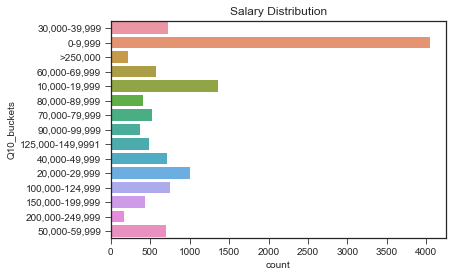

In [7]:
# Checking distribution of salaries
plt.style.use('seaborn-ticks')
sns.countplot(y="Q10_buckets", data=df).set_title('Salary Distribution')

# Deep dive into individual features and intuition behind choosing/discarding

### Education: 
This should naturally be a deciding factor in the final salary bucket someone ends up in. It's easy to notice that Bachelors and Professional degree holders earn similar salaries, and Highschool diploma holders and college dropouts all earn similar ranges of salaries - therefore, grouping them together, to reduce the number of features makes sense.

Also, there appears to be an increasing trend in the salaries and education - Higher the education, more the salary. Therefore, we can label encode this column.

Education
Bachelor’s degree                                                    3.032431
Doctoral degree                                                      5.153145
I prefer not to answer                                               2.652174
Master’s degree                                                      4.130709
No formal education past high school                                 3.360000
Professional degree                                                  3.248918
Some college/university study without earning a bachelor’s degree    3.417874
Name: Salary, dtype: float64


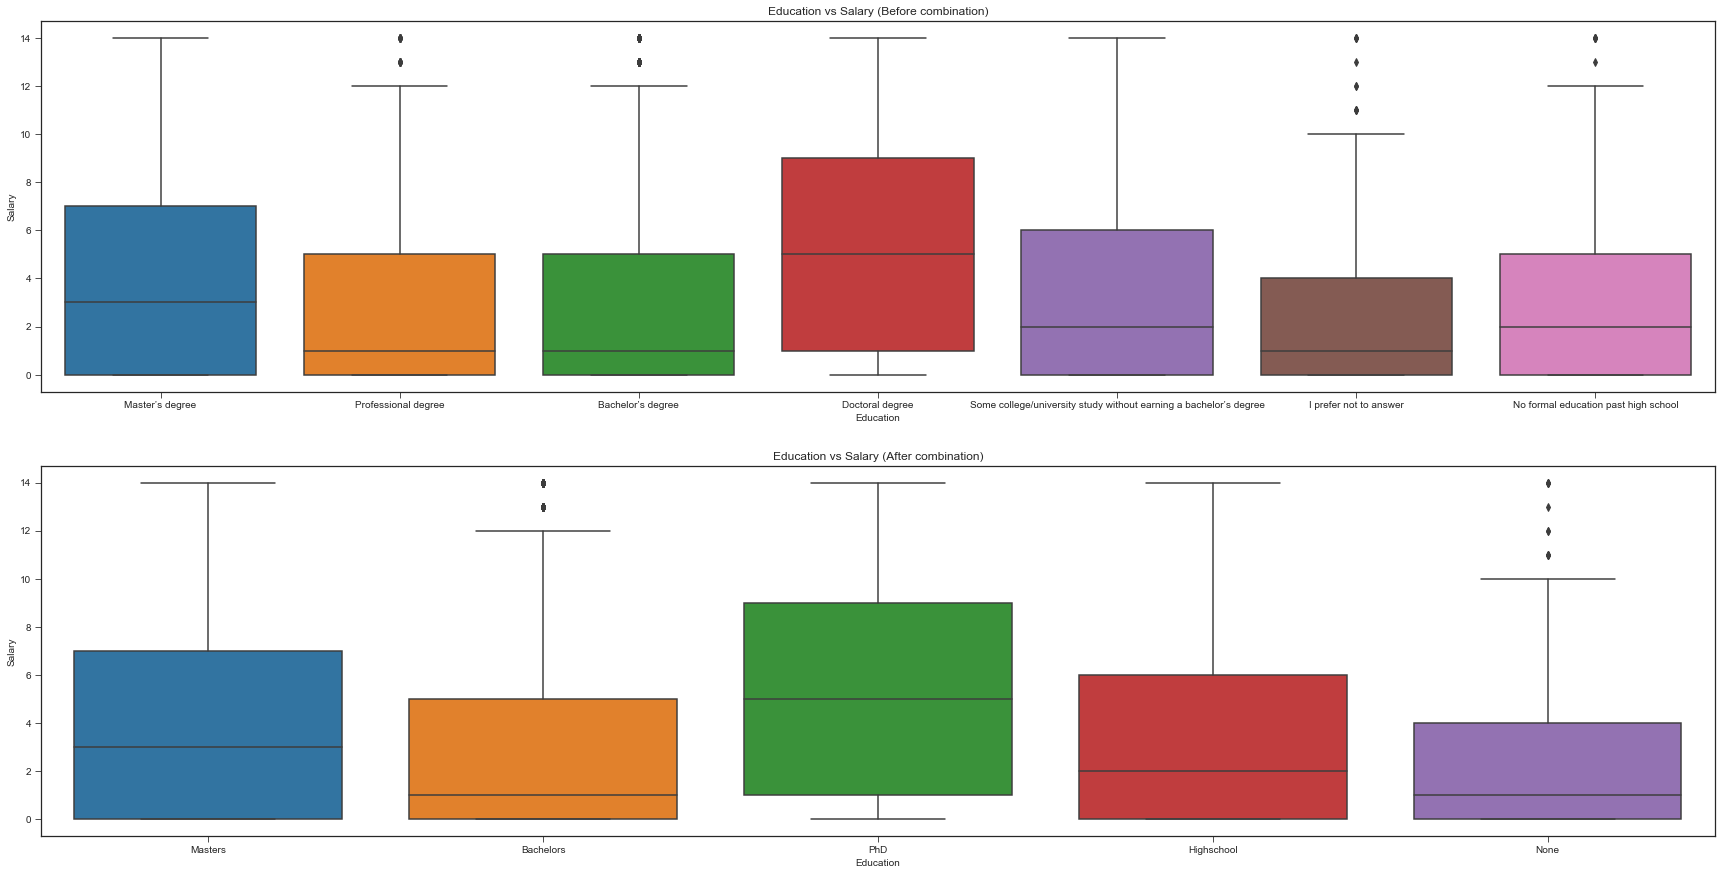

In [8]:
print(df.groupby('Education').mean()['Salary'])

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(2,1,1)
sns.boxplot(y="Salary", x="Education", data=df, ax=ax1).set_title('Education vs Salary (Before combination)')

# Renaming and grouping some categories together
df['Education'].replace('Master’s degree', 'Masters', inplace=True)
df['Education'].replace('Bachelor’s degree', 'Bachelors', inplace=True)
df['Education'].replace('Doctoral degree', 'PhD', inplace=True)
df['Education'].replace('Some college/university study without earning a bachelor’s degree', 'Highschool', inplace=True)
df['Education'].replace('I prefer not to answer', 'None', inplace=True)
df['Education'].replace('No formal education past high school', 'Highschool', inplace=True)
df['Education'].replace('Professional degree', 'Bachelors', inplace=True)

ax2 = fig.add_subplot(2,1,2)
sns.boxplot(y="Salary", x="Education", data=df, ax=ax2).set_title('Education vs Salary (After combination)')

# Encode to numbers based on education level
df['Education'].replace('Masters', 3, inplace=True)
df['Education'].replace('Bachelors', 2, inplace=True)
df['Education'].replace('PhD', 4, inplace=True)
df['Education'].replace('Highschool', 1, inplace=True)
df['Education'].replace('None', 0, inplace=True)
df['Education'].replace('Highschool', 1, inplace=True)
df['Education'].replace('Bachelors', 2, inplace=True)

### Country

We have to 1-hot encode country, or it would end up giving unnecessary relations between different countries. However, 1-hot encoding all the given countries would result in a large number of features. 

So it's better to group them by continents.

### Note:
USA seems to be much better off in terms of salaries than the rest of North America, so it's considered separately. (Graph depicting this in the Exploratory Data Analysis section)

In [9]:
country_to_continents = {'Brazil':'South America', 'India':'Asia', 'Japan':'Asia', 'Russia':'Asia', 'Germany':'Europe', 'United Kingdom of Great Britain and Northern Ireland': 'Europe', 'Spain':'Europe', 'Canada':'North America', 'France':'Europe', 'China':'Asia', 'Nigeria':'Africa', 'Australia':'Oceania', 'Italy':'Europe', 'Turkey':'Europe', 'Taiwan':'Poland', 'Ukraine':'Europe', 'Mexico':'North America', 'Colombia':'South America', 'Pakistan':'Asia', 'Netherlands':'Europe', 'South Korea':'Asia', 'Indonesia':'Asia', 'Singapore':'Asia', 'Argentina':'South America', 'Portugal':'Europe', 'South Africa':'Africa', 'Chile':'South America', 'Israel':'Asia', 'Viet Nam':'Asia', 'Switzerland':'Europe', 'Kenya':'Africa', 'Greece':'Europe', 'Sweden':'Europe', 'Morocco':'Africa', 'Egypt':'Africa', 'Bangladesh':'Asia', 'Belgium':'Asia', 'Iran, Islamic Republic of...':'Asia', 'Peru':'South America', 'Ireland':'Europe', 'Hong Kong (S.A.R.)':'Asia', 'Malaysia':'Asia', 'Republic of Korea':'Asia', 'Belarus':'Europe', 'Thailand':'Asia', 'Romania':'Europe', 'Austria':'Europe','Hungary':'Europe', 'Philippines':'Asia', 'New Zealand':'Oceania', 'Norway':'Europe', 'Denmark':'Europe', 'Czech Republic':'Europe', 'Saudi Arabia':'Asia', 'Algeria':'Africa', 'Tunisia':'Africa'}


df['Continents'] = df['Country'].replace(country_to_continents)

# Poland never gets added for some reason
df['Continents'].replace('Poland', 'Europe', inplace=True)

df.drop('Country', axis=1, inplace=True)

df['Continents'].unique()

array(['Europe', 'Asia', 'Oceania', 'United States of America', 'Other',
       'South America', 'Africa', 'North America'], dtype=object)

### Closest Associated Title:
The title of the employee can be considered to be a form of rank. We can explore this further and see if this is really the case.

In [10]:
print(df.groupby(['Title'])['Salary'].mean())
print(df['Title'].unique())
df['Title'].replace('Statistician', 'Data Scientist', inplace=True)
df['Title'].replace('Data Engineer', 'Data Scientist', inplace=True)
df['Title'].replace('Research Scientist', 'Other', inplace=True)
df['Title'].replace('Statistician', 'Data Scientist', inplace=True)
df['Title'].replace('Data Analyst', 'Analyst', inplace=True)
df['Title'].replace('Business Analyst', 'Analyst', inplace=True)
df['Title'].replace('DBA/Database Engineer', 'Software Engineer', inplace=True)

df['Title'].unique()

print(df.groupby(['Title'])['Salary'].mean())

Title
Business Analyst           3.233138
DBA/Database Engineer      3.848921
Data Analyst               2.908963
Data Engineer              3.958258
Data Scientist             4.667308
Other                      4.177507
Product/Project Manager    5.247376
Research Scientist         3.738994
Software Engineer          3.182845
Statistician               3.528517
Name: Salary, dtype: float64
['Software Engineer' 'Other' 'Data Scientist' 'Statistician'
 'Product/Project Manager' 'Data Analyst' 'Research Scientist'
 'Business Analyst' 'Data Engineer' 'DBA/Database Engineer']
Title
Analyst                    3.014293
Data Scientist             4.512348
Other                      3.974527
Product/Project Manager    5.247376
Software Engineer          3.219454
Name: Salary, dtype: float64


From the groupby, it is clear that the managers, data scientists and data engineers make the most. Therefore, we can group them into Analysts, Data Scientists, Others, Managers, and Software Engineers (Statistician would come under data scienctist)

We still preserve most of the statistics - Data scientists still average at ~4.5, software engineers at ~3.2, and so on. Therefore, this looks like a valid transformation

### Use of ML methods in company:
If a company doesn't use machine learning methods, then the data scientists are bound to earn a lower salary - this can be confirmed form the boxplot. Therefore, I grouped them into Well-defined ML models, recently started using ML models, and No.

Clearly, there's an increasing trend here too - those will well established ML methods earn more, so I label encode these as well, with 0 being no and 2 being well established ML methods.

ML Methods?
I do not know                                                                                2.555953
No (we do not use ML methods)                                                                2.573987
We are exploring ML methods (and may one day put a model into production)                    3.372534
We have well established ML methods (i.e., models in production for more than 2 years)       5.945809
We recently started using ML methods (i.e., models in production for less than 2 years)      4.325608
We use ML methods for generating insights (but do not put working models into production)    4.119475
Name: Salary, dtype: float64


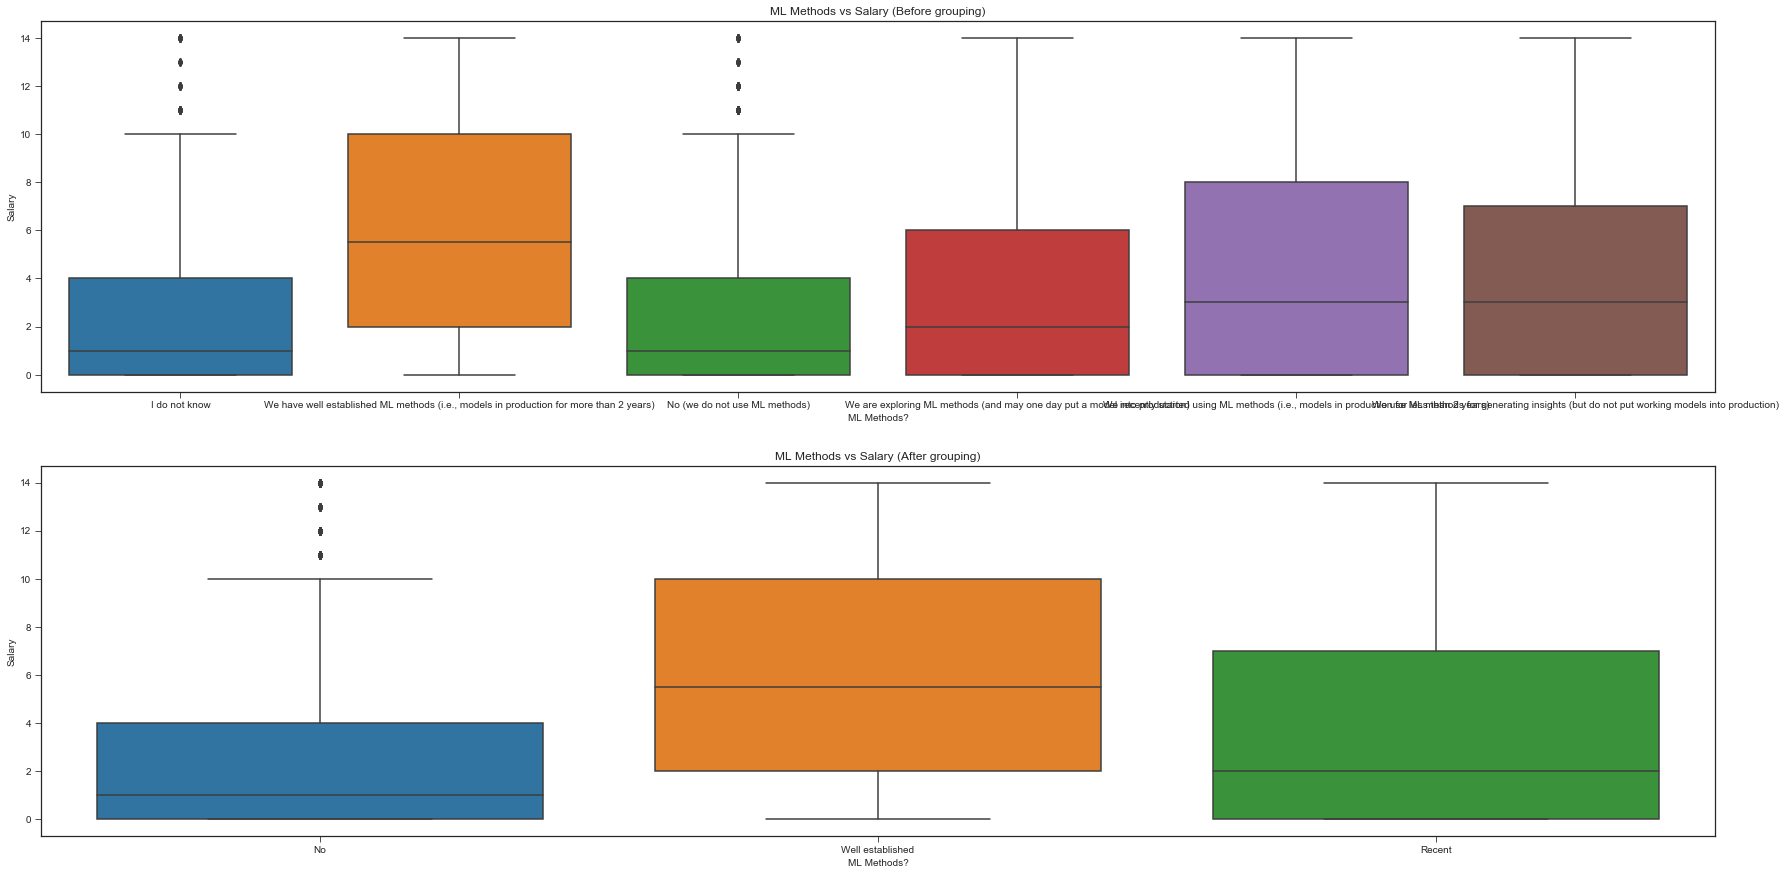

In [11]:
print(df.groupby('ML Methods?').mean()['Salary'])

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(2,1,1)
sns.boxplot(y="Salary", x="ML Methods?", data=df, ax=ax1).set_title('ML Methods vs Salary (Before grouping)')

df['ML Methods?'].replace('I do not know', 'No', inplace=True)
df['ML Methods?'].replace('No (we do not use ML methods)', 'No', inplace=True)
df['ML Methods?'].replace('We have well established ML methods (i.e., models in production for more than 2 years)', 'Well established', inplace=True)
df['ML Methods?'].replace('We are exploring ML methods (and may one day put a model into production)', 'Recent', inplace=True)
df['ML Methods?'].replace('We recently started using ML methods (i.e., models in production for less than 2 years)', 'Recent', inplace=True)
df['ML Methods?'].replace('We use ML methods for generating insights (but do not put working models into production)', 'Recent', inplace=True)

ax2 = fig.add_subplot(2,1,2)
sns.boxplot(y="Salary", x="ML Methods?", data=df, ax=ax2).set_title('ML Methods vs Salary (After grouping)')

# Label encode it
df['ML Methods?'].replace('No', 0, inplace=True)
df['ML Methods?'].replace('Well established', 2, inplace=True)
df['ML Methods?'].replace('Recent', 1, inplace=True)


### Amount of money spent on machine learning

The intuition is that if a company is capable of spending more money, then data scientists gain access to more sophisticated tools - the groupby shows this patter, where we see increasing mean salaries based on the amount of money the company invests in Machine Learning.

Since these are buckets, and there's a clear rising trend, I took the mid value of the bucket range as the feature. This will later be normalized, so we preserve the trend in the amount spent.

Money Spent
$0 (USD)             3.141902
$1-$99               1.991246
$10,000-$99,999      6.439274
$100-$999            3.043683
$1000-$9,999         4.392369
> $100,000 ($USD)    8.046953
Name: Salary, dtype: float64


Text(0.5, 1.0, 'Money Spent vs Salary (Mid-value)')

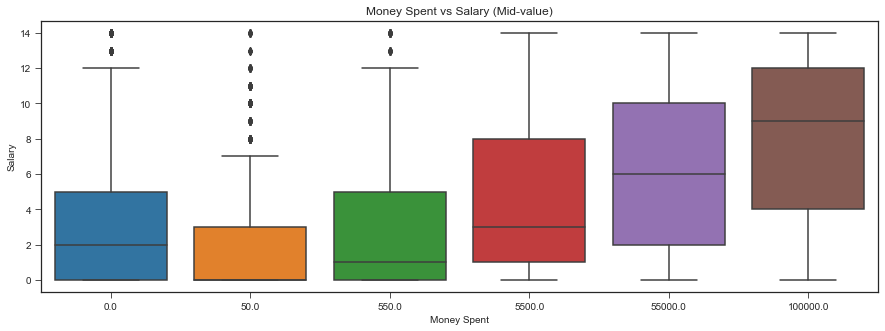

In [12]:
print(df.groupby('Money Spent')['Salary'].mean())

# Considering mid-values of buckets
df['Money Spent'].replace('$0 (USD)', 0, inplace=True)
df['Money Spent'].replace('> $100,000 ($USD)', 100000, inplace=True)
df['Money Spent'].replace('$10,000-$99,999', 55000, inplace=True)
df['Money Spent'].replace('$100-$999', 550, inplace=True)
df['Money Spent'].replace('$1000-$9,999', 5500, inplace=True)
df['Money Spent'].replace('$1-$99', 50, inplace=True)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
sns.boxplot(y="Salary", x="Money Spent", data=df, ax=ax).set_title('Money Spent vs Salary (Mid-value)')

In [13]:
df.head(2)

,Age,Gender,Education,Title,Company Size,Data Scientists,ML Methods?,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Money Spent,Q14,Coding Experience,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Salary,Q10_buckets,Continents
0,22-24,Male,3,Software Engineer,"1000-9,999 employees",0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"Basic statistical software (Microsoft Excel, G...",1-2 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,Python,R,SQL,NaN,NaN,Java,Javascript,NaN,NaN,MATLAB,NaN,NaN,CPUs,GPUs,NaN,NaN,NaN,Linear or Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"30,000-39,999",Europe
1,40-44,Male,2,Software Engineer,"> 10,000 employees",20+,2,Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,100000.0,"Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"0-9,999",Asia


### Role description

* I've grouped together those that analyze data as Data Scientists, and those that perform ML methods and gather inference as ML Engineers
* The idea behind this is that a data scientist is expected to understand the business aspect as well, whereas someone who is working purely on machine learning does not necessarily have to think about the business aspect. 
* This is justified by the plot - After grouping together those that analyze data from a business perspective, we see that data scientists earn more than generic ML engineers who work only with models

New Role
Data Scientist    4.806155
ML Engineer       3.781585
Other             2.708496
Name: Salary, dtype: float64

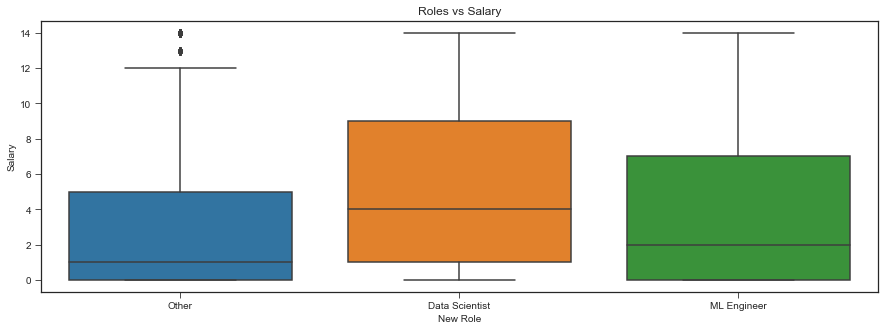

In [14]:
# Replaces roles with just data engineer, ML engineer or other
def changeRole(row):
    if (row['Q9_Part_1']):
        return 'Data Scientist'
    if (row['Q9_Part_2'] or row['Q9_Part_3'] or row['Q9_Part_4'] or row['Q9_Part_5'] or row['Q9_Part_6']):
        return 'ML Engineer'
    else:
        return 'Other'

df[['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8']] = df[['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8']].fillna(value=0)  
df['New Role'] = df.apply(lambda row: changeRole(row), axis=1)
df.drop(columns = ['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8'], axis=1, inplace = True)
df.head(2)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(y="Salary", x="New Role", data=df, ax=ax1).set_title('Roles vs Salary')

df.groupby('New Role')['Salary'].mean()

### Programming Languages

As we're concerned with classification of a data scientist's salary, it makes sense to group together languages that a data scientist would use, and others. Looking at the distribution again, this seems justified.

* We group together Python, R and SQL into one language called 'Data Science Languages'
* The other languages are grouped into 'Other'
* Those who don't use any language are grouped into 'None'

['Data Science Languages' 'Other' 'None']


Languages
Data Science Languages    4.091446
None                      3.347826
Other                     3.093123
Name: Salary, dtype: float64

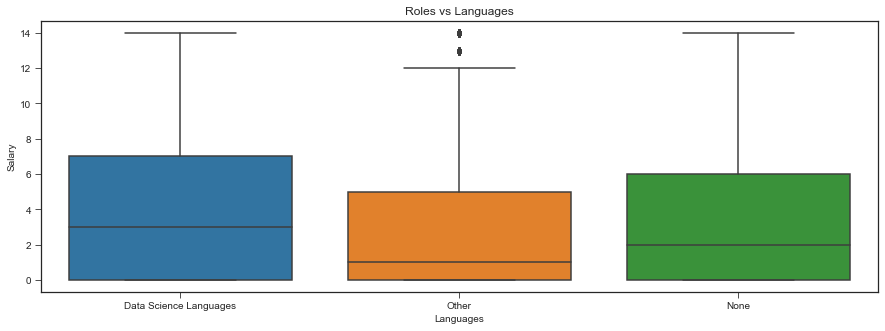

In [15]:
# Grouping together the languages Python R and SQL into data science languages, and other languages

column_list = []
for column in df.columns:
    if 'Q18' in column:
        column_list.append(column)
        df[column] = df[column].fillna(value=0)
        #print(column, df[column].unique())


def changeRole(row):
    if (row['Q18_Part_1'] or row['Q18_Part_2'] or row['Q18_Part_3']):
        return 'Data Science Languages'
    elif (row['Q18_Part_11']):
        return 'None'
    else:
        return 'Other'

df['Languages'] = df.apply(lambda row: changeRole(row), axis=1)

for column in df.columns:
    if 'Q18' in column:
        df.drop(column, axis=1, inplace=True)
print(df['Languages'].unique())

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(y="Salary", x="Languages", data=df, ax=ax1).set_title('Roles vs Languages')

df.groupby('Languages')['Salary'].mean()


### Hardware Used

* Combining into CPU, GPU, and others, we notice another trend - those that can use GPUs tend to earn more
* It's also clear that this data isn't skewed - an equivalent number of people use GPUs/CPUs/neither

['GPU' 'Other' 'CPU']
Hardware
CPU      3.779204
GPU      4.247557
Other    3.635784
Name: Salary, dtype: float64


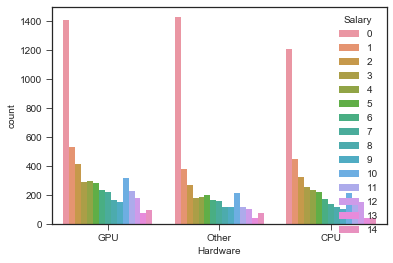

In [16]:
df[['Q21_Part_1', 'Q21_Part_2', 'Q21_Part_3', 'Q21_Part_4', 'Q21_Part_5']] = df[['Q21_Part_1', 'Q21_Part_2', 'Q21_Part_3', 'Q21_Part_4', 'Q21_Part_5']].fillna(value=0)

def changeRole(row):
    if (row['Q21_Part_2']):
        return 'GPU'
    elif (row['Q21_Part_1']):
        return 'CPU'
    else:
        return 'Other'


df['Hardware'] = df.apply(lambda row: changeRole(row), axis=1)
df.drop(columns = ['Q21_Part_1', 'Q21_Part_2', 'Q21_Part_3', 'Q21_Part_4', 'Q21_Part_5'], axis=1, inplace = True)

print(df['Hardware'].unique())
print(df.groupby('Hardware')['Salary'].mean())

#sns.boxplot(y="Salary", x="Hardware", data=df).set_title('Hardware vs Salary')
sns.countplot(x='Hardware', hue='Salary', data=df)

### Company size and number of data scientists

* Looking at the company size vs salary, it appears larger companies tend to pay more
* However, when we consider the number of data scientists to the size of the company, it appears that the salary also depends on the number of data scientists that work in the company. 
* So we consider both, with both of these features being transformed in the same as previous bucket-based features were - by considering mid-values, then normalizing later on

['1000-9,999 employees' '> 10,000 employees' '0-49 employees'
 '50-249 employees' '250-999 employees']
['0' '20+' '3-4' '1-2' '5-9' '10-14' '15-19']
Company Size
0-49 employees          2.893768
1000-9,999 employees    4.623656
250-999 employees       3.738340
50-249 employees        3.558429
> 10,000 employees      4.979359
Name: Salary, dtype: float64 


Company Size          Data Scientists
0-49 employees        0                  1.747613
                      1-2                3.092037
                      10-14              3.000000
                      15-19              4.387097
                      20+                2.696429
                      3-4                3.297636
                      5-9                3.455056
1000-9,999 employees  0                  3.004444
                      1-2                3.784387
                      10-14              4.718045
                      15-19              4.543307
                      20+                5.285369
   

Text(0.5, 1.0, 'Data Scientists vs Salary')

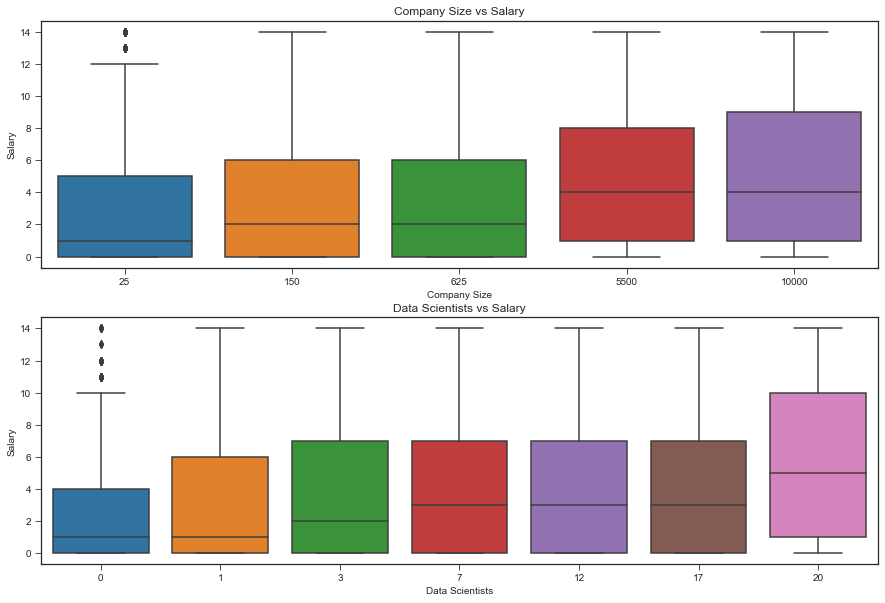

In [17]:
df.head(2)
print(df['Company Size'].unique())
print(df['Data Scientists'].unique())
print(df.groupby(['Company Size'])['Salary'].mean(), '\n\n')
print(df.groupby(['Company Size', 'Data Scientists'])['Salary'].mean())

df['Company Size'].replace('0-49 employees', 25, inplace=True)
df['Company Size'].replace('50-249 employees', 150, inplace=True)
df['Company Size'].replace('250-999 employees', 625, inplace=True)
df['Company Size'].replace('1000-9,999 employees', 5500, inplace=True)
df['Company Size'].replace('> 10,000 employees', 10000, inplace=True)

df['Data Scientists'].replace('0', 0, inplace=True)
df['Data Scientists'].replace('1-2', 1, inplace=True)
df['Data Scientists'].replace('3-4', 3, inplace=True)
df['Data Scientists'].replace('5-9', 7, inplace=True)
df['Data Scientists'].replace('10-14', 12, inplace=True)
df['Data Scientists'].replace('15-19', 17, inplace=True)
df['Data Scientists'].replace('20+', 20, inplace=True)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
sns.boxplot(y="Salary", x="Company Size", data=df, ax=ax1).set_title('Company Size vs Salary')
ax2 = fig.add_subplot(2,1,2)
sns.boxplot(y="Salary", x="Data Scientists", data=df, ax=ax2).set_title('Data Scientists vs Salary')

### Coding experience

Taking a look at the boxplot for coding experience and salary - we once again notice a trend: More experience in programming translates to a higher salary.

Therefore, these are encoded in a similar way, by taking the mid bucket values, and then normalizing later to preserve the relation

['1-2 years' 'I have never written code' '< 1 years' '20+ years'
 '3-5 years' '5-10 years' '10-20 years' nan]


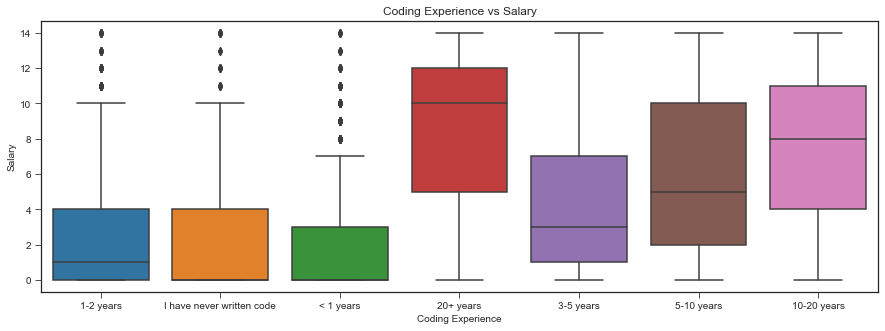

In [18]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(y="Salary", x="Coding Experience", data=df, ax=ax1).set_title('Coding Experience vs Salary')

print(df['Coding Experience'].unique())
df['Coding Experience'].replace('< 1 years', 0, inplace=True)
df['Coding Experience'].replace('I have never written code', 0, inplace=True)
df['Coding Experience'].replace('1-2 years', 1, inplace=True)
df['Coding Experience'].replace('3-5 years', 4, inplace=True)
df['Coding Experience'].replace('5-10 years', 7.5, inplace=True)
df['Coding Experience'].replace('10-20 years', 15, inplace=True)
df['Coding Experience'].replace('20+ years', 20, inplace=True)

### Now that we have removed most of what we don't need, and have modified most of the columns, let's take a look at the remaining columns to see if any redundant columns can be dropped:

* Q14, Q29-34 all discuss the platform they use, and therefore are dropped.
* By looking at some rows for Q17, we notice that people tend to use multiple cloud products, and therefore this cannot be a good measure for the salary
* Similarly, Q24 discusses ML models. 25-28 are all modifications of this question, where they try to ask what frameworks the user uses. Therefore, we consider only Q24, and drop the rest


Q24_Part_1 ['Linear or Logistic Regression' 0]
Q24_Part_2 [0 'Decision Trees or Random Forests']
Q24_Part_3 [0 'Gradient Boosting Machines (xgboost, lightgbm, etc)']
Q24_Part_4 [0 'Bayesian Approaches']
Q24_Part_5 [0 'Evolutionary Approaches']
Q24_Part_6 [0 'Dense Neural Networks (MLPs, etc)']
Q24_Part_7 [0 'Convolutional Neural Networks']
Q24_Part_8 [0 'Generative Adversarial Networks']
Q24_Part_9 [0 'Recurrent Neural Networks']
Q24_Part_10 [0 'Transformer Networks (BERT, gpt-2, etc)']
Q24_Part_11 [0 'None']
Q24_Part_12 [0 'Other']
['Basic' 'None' 'Specialized']


ML Division
Basic          4.135979
None           3.138966
Specialized    4.171303
Name: Salary, dtype: float64

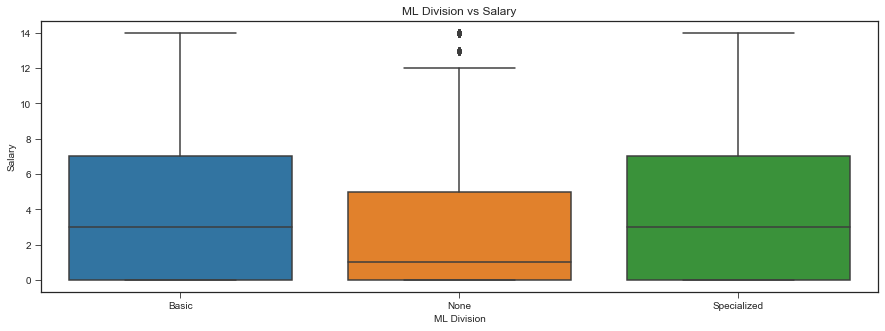

In [19]:
columns_to_drop = []
for column in df.columns:
    if 'Q14' in column or 'Q17' in column or 'Q25' in column or 'Q26' in column or 'Q27' in column or 'Q29' in column or 'Q30' in column or 'Q31' in column or 'Q32' in column or 'Q33' in column or 'Q34' in column:
        columns_to_drop.append(column)

df = df.drop(columns_to_drop, axis=1)

for column in df.columns:
    if '24' in column:
        df[column].fillna(value=0, inplace=True)
        print(column, df[column].unique())

        
def change(row):
    if row['Q24_Part_10'] or row['Q24_Part_9'] or row['Q24_Part_8'] or row['Q24_Part_7'] or row['Q24_Part_6'] or row['Q24_Part_5']:
        return 'Specialized'
    elif row['Q24_Part_1'] or row['Q24_Part_2'] or row['Q24_Part_3'] or row['Q24_Part_4']:
        return 'Basic'
    else:
        return 'None'

df['ML Division'] = df.apply(lambda row: change(row), axis=1)

for column in df.columns:
    if 'Q24' in column:
        df.drop(column, axis=1, inplace=True)
print(df['ML Division'].unique())

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(y="Salary", x="ML Division", data=df, ax=ax1).set_title('ML Division vs Salary')

df.groupby('ML Division')['Salary'].mean()

We see that the framework the person works on doesn't really affect their salary in any way. The averages, as well as maximum salaries are still the same. Therefore, we can safely remove this feature.

In [20]:
df.drop('ML Division', axis=1, inplace=True)

In [21]:
df.columns

Index(['Age', 'Gender', 'Education', 'Title', 'Company Size',
       'Data Scientists', 'ML Methods?', 'Money Spent', 'Coding Experience',
       'Salary', 'Q10_buckets', 'Continents', 'New Role', 'Languages',
       'Hardware'],
      dtype='object')

# Handling Missing Values

We have created an initial list of features that we can now work with. These are:

* Age
* Gender
* Continents
* Education
* Title
* Company Size
* Number of Data Scientists
* ML Methods used in company
* Money spent on ML in company
* Coding Experience
* Job Role
* Languages used
* Hardware used

Let's try to fill in all the missing values now

Age 0
Gender 0
Education 0
Title 0
Company Size 0
Data Scientists 0
ML Methods? 0
Money Spent 247
Coding Experience 1075
Salary 0
Q10_buckets 0
Continents 0
New Role 0
Languages 0
Hardware 0


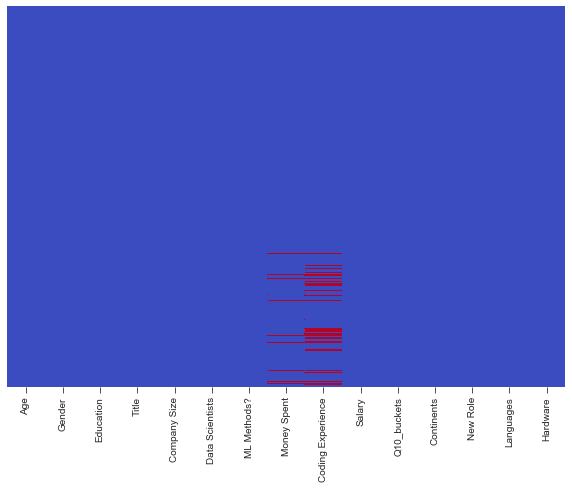

In [22]:
for column in df.columns:
    print(column, df[column].isna().sum())


fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

It looks like only Money Spent and Coding Experience columns have None values. The others have been already been taken care of while grouping them up together

Company Size  Money Spent
25            0.0            1163
              50.0            526
              550.0           739
              5500.0          660
              55000.0         280
              100000.0         92
150           0.0             660
              50.0            274
              550.0           397
              5500.0          374
              55000.0         224
              100000.0        112
625           0.0             556
              50.0            195
              550.0           324
              5500.0          263
              55000.0         180
              100000.0        106
5500          0.0             789
              50.0            227
              550.0           408
              5500.0          431
              55000.0         294
              100000.0        229
10000         0.0             870
              50.0            263
              550.0           467
              5500.0          395
              55000.0 

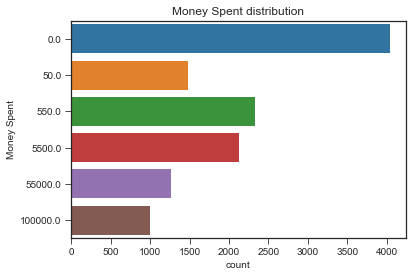

In [23]:
sns.countplot(y="Money Spent", data=df).set_title('Money Spent distribution')

df.groupby(['Company Size', 'Money Spent'])['Salary'].count()

Looks like regardless of the company size, the most common amount of Money Spent appears to be 0. Therefore, we fill in all the nan values with 0s

In [24]:
df['Money Spent'].fillna(value=0, inplace=True)
df['Money Spent'].unique()

array([0.0e+00, 1.0e+05, 5.5e+04, 5.5e+02, 5.5e+03, 5.0e+01])

### Handling zeros in Coding Experience

Let's try to correlate Coding Experience with Education to fill in zeroes. A person with higher education should be more likely to have some coding experience. Let's see if this is true

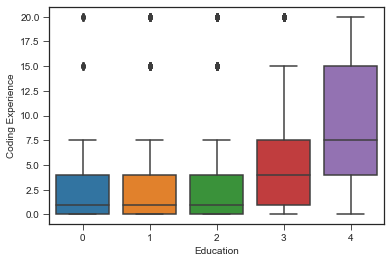

In [25]:
sns.boxplot(x='Education', y='Coding Experience', data=df)

In [26]:
df.groupby('Education')['Coding Experience'].mean()

Education
0    4.184713
1    3.681342
2    3.265250
3    4.388075
4    8.019876
Name: Coding Experience, dtype: float64

In [27]:
def change(experience, education):
    if experience == experience:
        return experience
    elif education == 0:
        return 4.18
    elif education == 1:
        return 3.68
    elif education == 2:
        return 3.27
    elif education == 3:
        return 4.39
    else:
        return 8.02
    
df['Coding Experience'] = df.apply(lambda row: change(row['Coding Experience'], row['Education']), axis=1)
df['Coding Experience'].unique()

array([ 1.  ,  0.  , 20.  ,  4.  ,  7.5 , 15.  ,  3.27,  8.02,  4.39,
        3.68,  4.18])

Age 0
Gender 0
Education 0
Title 0
Company Size 0
Data Scientists 0
ML Methods? 0
Money Spent 0
Coding Experience 0
Salary 0
Q10_buckets 0
Continents 0
New Role 0
Languages 0
Hardware 0


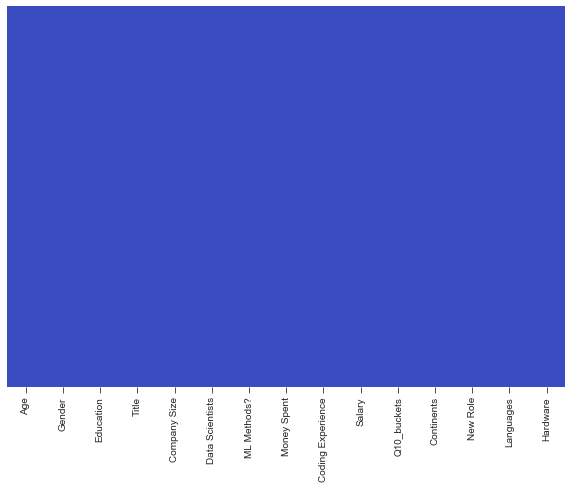

In [28]:
for column in df.columns:
    print(column, df[column].isna().sum())


fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

All of the missing values have been filled now.

# Encoding features

Now that all the missing values have been handled, we can encode all of features, and possibly reduce the dimensions somehow

In [29]:
for column in df.columns:
    print(column, df[column].unique())

Age ['22-24' '40-44' '50-54' '55-59' '30-34' '18-21' '35-39' '25-29' '45-49'
 '60-69' '70+']
Gender ['Male' 'Female' 'Prefer to self-describe' 'Prefer not to say']
Education [3 2 4 1 0]
Title ['Software Engineer' 'Other' 'Data Scientist' 'Product/Project Manager'
 'Analyst']
Company Size [ 5500 10000    25   150   625]
Data Scientists [ 0 20  3  1  7 12 17]
ML Methods? [0 2 1]
Money Spent [0.0e+00 1.0e+05 5.5e+04 5.5e+02 5.5e+03 5.0e+01]
Coding Experience [ 1.    0.   20.    4.    7.5  15.    3.27  8.02  4.39  3.68  4.18]
Salary [ 3  0 14  6  1  8  7  9 11  4  2 10 12 13  5]
Q10_buckets ['30,000-39,999' '0-9,999' '>250,000' '60,000-69,999' '10,000-19,999'
 '80,000-89,999' '70,000-79,999' '90,000-99,999' '125,000-149,9991'
 '40,000-49,999' '20,000-29,999' '100,000-124,999' '150,000-199,999'
 '200,000-249,999' '50,000-59,999']
Continents ['Europe' 'Asia' 'Oceania' 'United States of America' 'Other'
 'South America' 'Africa' 'North America']
New Role ['Other' 'Data Scientist' 'ML Engineer

We can change Age to the mid value of the bucket and normalize it

In [30]:
df['Age'].replace('22-24', 23, inplace=True)
df['Age'].replace('40-44', 42, inplace=True)
df['Age'].replace('50-54', 52, inplace=True)
df['Age'].replace('55-59', 57, inplace=True)
df['Age'].replace('30-34', 32, inplace=True)
df['Age'].replace('18-21', 20, inplace=True)
df['Age'].replace('35-39', 37, inplace=True)
df['Age'].replace('25-29', 27, inplace=True)
df['Age'].replace('45-49', 47, inplace=True)
df['Age'].replace('60-69', 65, inplace=True)
df['Age'].replace('70+', 70, inplace=True)

print(df['Age'].unique())

#df['Age'] = (df['Age'] - df['Age'].min())/(df['Age'].max() - df['Age'].min())

df.head(5)

[23 42 52 57 32 20 37 27 47 65 70]


,Age,Gender,Education,Title,Company Size,Data Scientists,ML Methods?,Money Spent,Coding Experience,Salary,Q10_buckets,Continents,New Role,Languages,Hardware
0,23,Male,3,Software Engineer,5500,0,0,0.0,1.0,3,"30,000-39,999",Europe,Other,Data Science Languages,GPU
1,42,Male,2,Software Engineer,10000,20,2,100000.0,0.0,0,"0-9,999",Asia,Data Scientist,Other,Other
2,42,Male,3,Other,10000,20,0,55000.0,1.0,14,">250,000",Oceania,Other,Data Science Languages,GPU
3,23,Male,2,Other,25,0,0,0.0,0.0,0,"0-9,999",Asia,Other,Data Science Languages,GPU
4,52,Male,3,Data Scientist,25,3,2,55000.0,20.0,6,"60,000-69,999",Europe,ML Engineer,Data Science Languages,GPU


### 1 hot encoding

We can now convert all the categorical variables into one-hot encoded features

In [31]:
df['Gender'] = pd.Categorical(df['Gender'])
dfDummies = pd.get_dummies(df['Gender'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)
#df.drop('Gender', axis=1, inplace=True)

df['New Role'] = pd.Categorical(df['New Role'])
dfDummies = pd.get_dummies(df['New Role'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)
#df.drop('New Role', axis=1, inplace=True)

df['Languages'] = pd.Categorical(df['Languages'])
dfDummies = pd.get_dummies(df['Languages'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)
#df.drop('Languages', axis=1, inplace=True)

df['Hardware'] = pd.Categorical(df['Hardware'])
dfDummies = pd.get_dummies(df['Hardware'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)
#df.drop('Hardware', axis=1, inplace=True)

df['Title'] = pd.Categorical(df['Title'])
dfDummies = pd.get_dummies(df['Title'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)
#df.drop('Title', axis=1, inplace=True)

df['Continents'] = pd.Categorical(df['Continents'])
dfDummies = pd.get_dummies(df['Continents'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)
#df.drop('Continents', axis=1, inplace=True)

df.head()

,Age,Gender,Education,Title,Company Size,Data Scientists,ML Methods?,Money Spent,Coding Experience,Salary,Q10_buckets,Continents,New Role,Languages,Hardware,category_Female,category_Male,category_Prefer not to say,category_Prefer to self-describe,category_Data Scientist,category_ML Engineer,category_Other,category_Data Science Languages,category_None,category_Other,category_CPU,category_GPU,category_Other,category_Analyst,category_Data Scientist,category_Other,category_Product/Project Manager,category_Software Engineer,category_Africa,category_Asia,category_Europe,category_North America,category_Oceania,category_Other,category_South America,category_United States of America
0,23,Male,3,Software Engineer,5500,0,0,0.0,1.0,3,"30,000-39,999",Europe,Other,Data Science Languages,GPU,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,42,Male,2,Software Engineer,10000,20,2,100000.0,0.0,0,"0-9,999",Asia,Data Scientist,Other,Other,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2,42,Male,3,Other,10000,20,0,55000.0,1.0,14,">250,000",Oceania,Other,Data Science Languages,GPU,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,23,Male,2,Other,25,0,0,0.0,0.0,0,"0-9,999",Asia,Other,Data Science Languages,GPU,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,52,Male,3,Data Scientist,25,3,2,55000.0,20.0,6,"60,000-69,999",Europe,ML Engineer,Data Science Languages,GPU,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0


# Exploratory Data Analysis

Consider the following features: 
* Education
* Age
* Continents

### Education

In [32]:
df.groupby('Education')['Salary'].mean()

Education
0    2.652174
1    3.404453
2    3.058593
3    4.130709
4    5.153145
Name: Salary, dtype: float64

Text(0.5, 1.0, 'Education vs Salary')

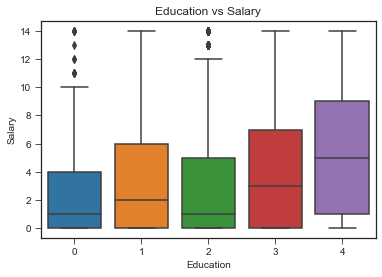

In [33]:
sns.boxplot(y="Salary", x="Education", data=df).set_title('Education vs Salary')

It's clear that having a higher education level (i.e., Masters or PhD, which is represented by 3 and 4 here) helps in earning a higher salary.

Conversely, having a lower education level corresponds to lower salaries - this is not just the mean, even the maximum salary earned gets affected. The maximum salary one without a degree can obtain is at 10, while the maximum salary one with a PhD can obtain is at 14 (these numbers are Q10_Encoded, not Q10_Buckets)

### Age

Text(0, 0.5, 'Salary (Mean)')

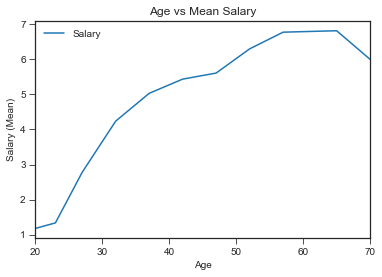

In [34]:
ax = df.groupby('Age')['Salary'].mean().plot(legend=True, title='Age vs Mean Salary')
ax.set_xlabel('Age')
ax.set_ylabel('Salary (Mean)')

Another trend we see is age. As the age increases, people tend to get higher salaries. This implies that age could be an important factor in determining the salary bucket.

### Continents

Text(0.5, 1.0, 'Continents vs Salary')

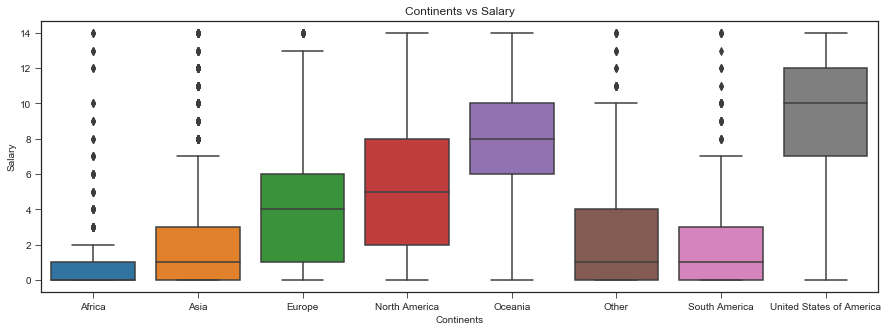

In [35]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(y="Salary", x="Continents", data=df, ax = ax1).set_title('Continents vs Salary')

It's evident that even the continent where a person works affects their salary. Data scientists in the USA make much more than than one in Asia or Africa. Therefore, this also becomes an important feature in attempting to predict salaries.

## Feature Importance

Let's consider the correlation matrix for the variables:

In [36]:
df.corr(method='pearson')

,Age,Education,Company Size,Data Scientists,ML Methods?,Money Spent,Coding Experience,Salary,category_Female,category_Male,category_Prefer not to say,category_Prefer to self-describe,category_Data Scientist,category_ML Engineer,category_Other,category_Data Science Languages,category_None,category_Other,category_CPU,category_GPU,category_Other,category_Analyst,category_Data Scientist,category_Other,category_Product/Project Manager,category_Software Engineer,category_Africa,category_Asia,category_Europe,category_North America,category_Oceania,category_Other,category_South America,category_United States of America
Age,1.000000,0.153843,0.030760,0.003891,-0.018550,0.151628,0.419703,0.363384,-0.066719,0.055249,0.017236,0.025308,-0.009886,-0.021962,0.029014,-0.018331,0.030860,0.012446,0.019282,-0.038759,0.021899,-0.065691,-0.097978,0.151873,0.124899,-0.048519,-0.077236,-0.230816,0.074461,0.047755,0.071483,0.003020,0.028817,0.184557
Education,0.153843,1.000000,0.031053,0.097540,0.134644,0.063209,0.245148,0.161968,0.051438,-0.038236,-0.031513,-0.009563,0.071228,0.081287,-0.144253,0.081552,-0.013368,-0.079957,0.039019,0.050655,-0.093084,-0.095344,0.090164,0.169144,-0.015745,-0.184326,-0.038514,-0.156716,0.144587,0.000920,0.003155,-0.001192,-0.033623,0.082939
Company Size,0.030760,0.031053,1.000000,0.515541,0.147432,0.174504,0.073411,0.181371,-0.012988,0.012969,-0.005594,0.009259,0.080444,-0.057780,-0.036953,0.026261,0.024849,-0.031531,0.018180,-0.021827,0.004984,0.009949,0.014486,-0.035267,0.023259,-0.003182,-0.091690,0.051319,-0.039923,-0.014811,-0.009383,-0.100238,-0.026879,0.120009
Data Scientists,0.003891,0.097540,0.515541,1.000000,0.331850,0.247327,0.141185,0.213976,0.019650,-0.020257,0.000955,0.008396,0.155885,0.025355,-0.187245,0.053463,-0.009823,-0.052207,-0.013809,0.041304,-0.030102,-0.010626,0.083276,-0.012558,0.003350,-0.078312,-0.072157,0.003710,-0.026160,-0.010393,0.002133,-0.071487,-0.044146,0.142733
ML Methods?,-0.018550,0.134644,0.147432,0.331850,1.000000,0.270664,0.219166,0.267127,-0.041883,0.043906,-0.005456,-0.015360,0.493430,0.259021,-0.743233,0.170784,-0.066880,-0.159729,-0.012044,0.196596,-0.197165,-0.095251,0.256192,-0.097067,-0.019084,-0.106031,-0.085247,-0.030701,0.040761,-0.010914,0.014217,-0.078357,-0.048300,0.122141
Money Spent,0.151628,0.063209,0.174504,0.247327,0.270664,1.000000,0.257543,0.377894,-0.036526,0.026589,0.022563,0.010588,0.192070,0.000330,-0.204680,0.076376,-0.007658,-0.075847,-0.010027,0.089407,-0.085099,-0.056859,0.098058,-0.033631,0.060715,-0.063286,-0.064112,-0.107030,-0.012465,-0.000134,0.060536,-0.035405,-0.037528,0.211910
Coding Experience,0.419703,0.245148,0.073411,0.141185,0.219166,0.257543,1.000000,0.423262,-0.047055,0.036334,0.024151,0.009517,0.164822,0.028805,-0.199661,0.100440,-0.014206,-0.098923,0.013854,0.092248,-0.112096,-0.114914,0.135357,0.062807,-0.003036,-0.117481,-0.076422,-0.219399,0.086157,0.025609,0.072843,-0.031800,-0.032445,0.229930
Salary,0.363384,0.161968,0.181371,0.213976,0.267127,0.377894,0.423262,1.000000,-0.062403,0.052285,0.014867,0.022019,0.202630,-0.016211,-0.201989,0.089443,-0.010180,-0.088583,-0.022306,0.062925,-0.044586,-0.097166,0.105236,0.006904,0.075251,-0.084258,-0.149058,-0.348169,0.042299,0.049895,0.132560,-0.090895,-0.129995,0.553652
category_Female,-0.066719,0.051438,-0.012988,0.019650,-0.041883,-0.036526,-0.047055,-0.062403,1.000000,-0.941277,-0.048157,-0.020299,-0.018182,-0.024114,0.039655,-0.057940,0.030298,0.052680,-0.012869,-0.115051,0.135378,0.067939,-0.001018,0.006155,-0.020669,-0.056784,0.020794,-0.025543,-0.008855,0.024394,0.004702,-0.003011,-0.034009,0.042746
category_Male,0.055249,-0.038236,0.012969,-0.020257,0.043906,0.026589,0.036334,0.052285,-0.941277,1.000000,-0.264732,-0.111586,0.024937,0.018828,-0.042393,0.067564,-0.034661,-0.061563,0.019974,0.110524,-0.137691,-0.061034,0.008782,-0.014126,0.020318,0.049517,-0.012700,0.032209,0.006602,-0.028350,-0.004675,-0.013951,0.040277,-0.045241


This matrix tells us quite a few things:

* The feature most related to the salary is coding experience - this makes sense because the more experience a person has in programming, the higher up the work chain they're going to be
* Surprisingly, education does not have a high correlation with salary, but it's not extremely low - therefore we still consider this feature
* The age of a person also has a pretty high correlation with Salary - this is further proved by the boxplot that's shown above.

# Feature Selection

#### Note: Most of the features were dropped/selected during the data cleaning section. This section will provide  justification on why those features were dropped/selected

#### Feature Engineering: 
Feature engineering in general is important because feeding a model input data by itself would naturally lead to terribly predictions. Data by itself can contain mislabelled information, missing information, or outliers that need to be dealth with. 
In this assignment, feature engineering was performed using the following techniques:
* Imputing - Checking for mode/mean/media, and correspondingly making a decision to fill in the missing values with one of those
* Dropping - This was done for the Salary column. When our prediction target has missing values, there is no point in using it. Imputing the target seems absurd to me.
* Normalization of bins - Some features have very large bucket ranges. These were modified to take the mean of the lower and upper limits of each bucket, then normalized later

#### Dropped Features and reasoning:

* Media Sources - This is highly subjective to the individual. If someone enjoys one particular media source, it cannot mean that they tend to earn more or less.
* Platforms to complete courses - This goes hand in hand with education. Therefore, it was dropped.
* Primary tool - A graph above describes how tools and frameworks don't affect salary at all. Most data scientists tend to work with most tools available to them, it also depends on the amount of money the company is willing to spend
* IDEs - Similar reasoning to primary tool. Another idea is that people may use multiple IDEs, making it almost impossible to identify trends.
* Computing platforms - There are several questions based on this. A data scientist will be using multiple platforms - this depends once agian on the amount of money the company is willing to spend
* Recommended programming language - This is highly subject to bias, what a person recommends someone to learn might not be the most in-demand language.

#### After all of these considerations, the features selected are:
* Age
* Gender
* Continents
* Education
* Title
* Company Size
* Number of Data Scientists
* ML Methods used in company
* Money spent on ML in company
* Coding Experience
* Job Role
* Languages used
* Hardware used


Dropping some categorical features that have been 1 hot encoded

In [37]:
df.drop('Gender', axis=1, inplace=True)
df.drop('New Role', axis=1, inplace=True)
df.drop('Languages', axis=1, inplace=True)
df.drop('Hardware', axis=1, inplace=True)
df.drop('Title', axis=1, inplace=True)
df.drop('Continents', axis=1, inplace=True)

### Extra Trees for feature selection:

With tree based classifiers, we get a feature importance method that prints out numerical values for the importance of each feature. Applying this, we can perform feature selection.

[0.13150862 0.08336974 0.10041456 0.10696378 0.03753505 0.10657903
 0.09573197 0.01279595 0.01397358 0.00392833 0.00084902 0.01522653
 0.01426991 0.01074221 0.00925798 0.00157573 0.00907547 0.02186978
 0.0219109  0.01864793 0.01848753 0.02390725 0.02173051 0.01206158
 0.02028186 0.00794816 0.01665607 0.01272122 0.00624055 0.00508851
 0.00667746 0.0075741  0.02439914]


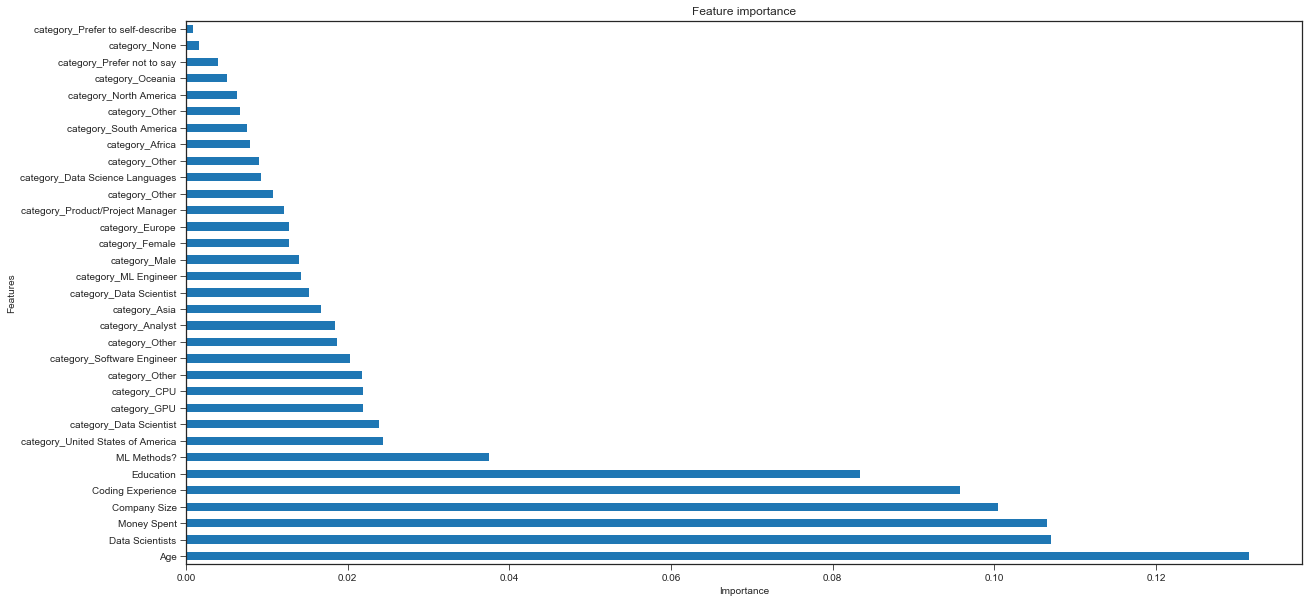

In [38]:
X = df.drop(['Q10_buckets', 'Salary'], axis=1)
y = df['Salary']
plt.figure(figsize=(20,10))
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(100).plot(kind='barh')

plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

It looks like the feature prefer to self-describe is the least important feature - An intuition behind this would be that it could possibly be a male, female, or other therefore it doesn't give much information to the model.

So we can safely drop this feature

In [39]:
df.drop('category_Prefer to self-describe', axis=1, inplace=True)

# Model Implementation

In [40]:
df.head(2)

,Age,Education,Company Size,Data Scientists,ML Methods?,Money Spent,Coding Experience,Salary,Q10_buckets,category_Female,category_Male,category_Prefer not to say,category_Data Scientist,category_ML Engineer,category_Other,category_Data Science Languages,category_None,category_Other,category_CPU,category_GPU,category_Other,category_Analyst,category_Data Scientist,category_Other,category_Product/Project Manager,category_Software Engineer,category_Africa,category_Asia,category_Europe,category_North America,category_Oceania,category_Other,category_South America,category_United States of America
0,23,3,5500,0,0,0.0,1.0,3,"30,000-39,999",0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,42,2,10000,20,2,100000.0,0.0,0,"0-9,999",0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0


In [41]:
X = df.drop(['Q10_buckets', 'Salary'], axis = 1)
y = df['Salary']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 25, test_size = 0.3)

scaler = StandardScaler()

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))

0.34423230821996115


In [44]:
predictions = model.predict(X_test)

TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]

total = TN + FP + FN + TP
acc = (TP + TN)/float(total)

print(acc)
print(accuracy_score(y_test, predictions))

0.7543296985246953
0.3456


# 10-fold Cross Validation without multiclass ordinal regression

Need to perform 10-fold cross val on only training set:

In [45]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)
best_model = LogisticRegression()
max_acc = 0

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X_train):
    local_x_train, local_x_test = X_train.values[train_idx], X_train.values[test_idx]
    local_y_train, local_y_test = y_train.values[train_idx], y_train.values[test_idx]
    
    local_x_train = scaler.fit_transform(local_x_train)
    local_x_test = scaler.fit_transform(local_x_test)
    
    model.fit(local_x_train, local_y_train)
    predictions = model.predict(local_x_test)
    
    acc = (predictions == local_y_test).sum()/len(local_y_test)
    
    if acc > max_acc:
        best_model = model
    
    accuracy[np_idx] = acc*100
    np_idx += 1
    
    print("Fold {}: Accuracy: {}%".format(np_idx, round(acc, 4)))
    
print("Average score: {}%, stddev: {}".format(round(np.mean(accuracy), 3), round(np.std(accuracy), 3)))

Fold 1: Accuracy: 0.3314%
Fold 2: Accuracy: 0.3383%
Fold 3: Accuracy: 0.3223%
Fold 4: Accuracy: 0.3269%
Fold 5: Accuracy: 0.3474%
Fold 6: Accuracy: 0.3634%
Fold 7: Accuracy: 0.3497%
Fold 8: Accuracy: 0.3776%
Fold 9: Accuracy: 0.3696%
Fold 10: Accuracy: 0.3593%
Average score: 34.858%, stddev: 1.784


<module 'matplotlib.pyplot' from '/Users/ragnarok/anaconda3/envs/developer/lib/python3.7/site-packages/matplotlib/pyplot.py'>

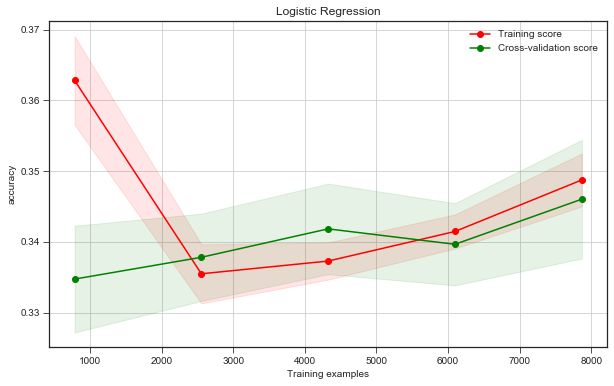

In [46]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

plot_learning_curve(model,'Logistic Regression', X_train, y_train, cv=10)

This graph depicts the accuracies during cross-validation and training. 

Over time, the training and cross-validation scores match, and there seems to be an upward trend with more datapoints. Perhaps with more data, the model could perform better

# Model Tuning

Since I didn't use L1 or L2 regression, the only hyperparameter I could be dealing with is a solver, as described in the tutorial

In [51]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X_train):
            local_X_train, local_X_test = X_train.values[train_idx], X_train.values[test_idx]
            local_y_train, local_y_test = y_train.values[train_idx], y_train.values[test_idx]

            local_X_train = scaler.fit_transform(local_X_train)
            local_X_test = scaler.transform(local_X_test)

            model.fit(local_X_train, local_y_train)

            predictions = model.predict(local_X_test)

            TN = confusion_matrix(local_y_test, predictions)[0][0]
            FP = confusion_matrix(local_y_test, predictions)[0][1]
            FN = confusion_matrix(local_y_test, predictions)[1][0]
            TP = confusion_matrix(local_y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.001, 'solver': 'liblinear'}
Best Score: 75.042%(1.851%)

The optimal log model uses C=0.001, and a liblinear solver, and has a cross validation score of 75.042% with a standard deviation of 1.851%


# Now we perform multiclass-ordinal logistic regression

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 25, test_size = 0.3)
scaler = StandardScaler()

result = []
for i in range(13):
    local_y_train = y_train.copy()
    local_X_train = X_train.copy()
    # Modify values so we have 0 and 1s for everything at each step
    for idx, val in local_y_train.iteritems():
        local_y_train[idx] = 0 if val < i + 1 else 1
    model = LogisticRegression()
    local_x_train = scaler.fit_transform(local_x_train)
    model.fit(local_X_train, local_y_train)
    result.append(model.predict_proba(X_test).round(3)[:,0])
final_result = []
for i in range(1,13):
    final_result.append(result[i] - result[i-1])
final_result.append(np.ones(3750) - result[-1])

result_df = pd.DataFrame()
for i in range(13):
    result_df['Bucket {}'.format(i)] = final_result[i]
y_test = y_test.reset_index(drop = True)
result_df['Most Likely Bucket'] = result_df.idxmax(axis=1)
result_df['Actual Bucket'] = y_test

result_df

,Bucket 0,Bucket 1,Bucket 2,Bucket 3,Bucket 4,Bucket 5,Bucket 6,Bucket 7,Bucket 8,Bucket 9,Bucket 10,Bucket 11,Bucket 12,Most Likely Bucket,Actual Bucket
0,0.111,0.257,-0.089,0.160,0.032,0.016,0.022,0.010,0.003,0.022,0.015,-0.001,0.018,Bucket 1,14
1,0.095,-0.161,0.189,-0.212,0.054,0.146,0.088,0.048,0.062,0.117,0.103,0.076,0.062,Bucket 2,4
2,0.009,0.034,0.003,0.045,0.015,0.039,0.053,0.077,0.085,0.222,0.090,0.100,0.177,Bucket 9,10
3,0.071,-0.029,0.159,-0.081,0.110,-0.156,0.145,0.160,0.188,0.184,0.066,0.036,0.019,Bucket 8,8
4,0.032,0.147,-0.050,0.215,0.009,0.291,0.059,-0.015,-0.035,0.110,0.047,0.035,0.041,Bucket 5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,0.089,-0.165,0.233,-0.219,0.062,0.001,0.071,0.073,0.144,0.226,0.208,0.073,0.030,Bucket 2,10
3746,0.025,-0.038,0.061,-0.060,0.006,0.009,0.012,0.025,0.040,0.142,0.170,0.435,0.144,Bucket 11,10
3747,0.096,0.025,0.093,-0.006,0.094,0.058,0.034,0.037,0.009,0.011,0.011,0.004,0.015,Bucket 0,2
3748,0.102,0.257,-0.067,0.129,0.034,0.002,0.024,0.009,0.005,0.006,0.002,-0.003,0.006,Bucket 1,5


### Note:

This dataframe can be interpreted as follows:
Probability of a particular example data belonging to one of the buckets.

* The 'Most Likely Bucket' column is the predicted bucket, based on highest probability
* The 'Actual Bucket' column is the y_test values - which is the real bucket

Clearly, a lot of the rows don't match - this results in the 35% accuracy. This can be attributed to underfitting

# Testing and Discussion

To get the test accuracies, we use the best_model that was defined during the 10-fold cross validation. We essentially get the model that performs the best out of the 10 folds.

In [53]:
X_test = scaler.fit_transform(X_test)
final_prediction = best_model.predict(X_test)
print(accuracy_score(y_test, final_prediction))

0.35573333333333335


#### Based on the training score and cross-validation score graph given above, we can infer a few things from this model:

* Both the training and test sets end up with similar accuracies
* It looks like an underfit, since both of them have close, but very low scores (~35% model accuracy)
* Looking at the distribution between the y_test and predicted values, we notice a large skew towards the 0.0. This can be attributed to the fact that the dataset itself has more datapoints that correspond to Salary 0 (i.e., first bucket)

* On the training set, all 10 folds give similar accuracies - this implies that there is low variance. This can be justified, because if there was high variance, then each fold would end up giving extremely different scores, as the model tries to refit itself according to the new set of data points.

Text(0.5, 1.0, 'Distribution of actual and predicted salaries (encoded)')

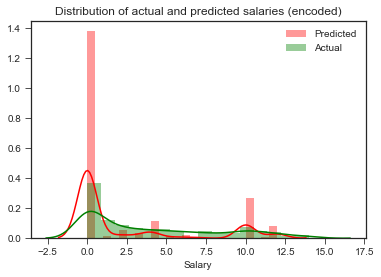

In [54]:
sns.distplot(final_prediction, color = 'red')
sns.distplot(y_test, color = 'green')
plt.legend(labels=['Predicted', 'Actual'])
plt.title('Distribution of actual and predicted salaries (encoded)')

#### Possible ways to increase accuracy:


* A dataset that is not skewed - or some way of handling the skewness in this dataset. The provided data is highly skewed towards the salary bucket corresponding to 0 in the Q10_encoded column. This skew reflects on the final distribution as shown above, where most of the datapoints are classified as belonging to bucket 0.
* Better feature engineering - I have selected features based on their trends with the salary, and also based on the Extra Trees Classifier's feature importance. However, this still appears to be lacking, as the selected features result in underfitting of the model - which implies more complexity, i.e., more features are required.